In [102]:
!pip install scikit-learn
!pip install pandas
!pip install seaborn 
!pip install matplotlib
!pip install imblearn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [103]:
import sklearn
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import glob
import re
from pathlib import Path
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE

In [3]:
#convert the txt files to csv files
directories = ['heart_rate','motion','steps','labels']

for d in directories:
    for name in os.listdir(d):
        with open(os.path.join(d, name)) as f:
             file_path = os.path.join(d, name)
             dir_name = f"{d}_csv"
             os.makedirs(dir_name,exist_ok=True)
             df1 = pd.read_csv(file_path)
             csv_file_path = os.path.join(dir_name, f"{os.path.splitext(name)[0]}")
             df1.to_csv(csv_file_path + '.csv', 
                      index = None)

In [4]:
# #sanity check 
# directories = ['steps_csv', 'heart_rate_csv', 'labels_csv', 'motion_csv']
# counters = {'steps_csv': 0, 'heart_rate_csv': 0, 'labels_csv': 0, 'motion_csv': 0}
# for d in directories:
#     for name in os.listdir(d):
#         counters[d] += 1

# for key, value in counters.items():
#     print(f"{key}: {value} files found")        

In [5]:
# file_path = "motion_csv/2598705_acceleration.csv"
# with open(file_path, 'r') as f:
#     for _ in range(5):
#         # print(f.readline())

In [6]:
#outliers using IQR Method 
count = {'steps_csv':0, 'heart_rate_csv':0, 'labels_csv':0, 'motion_csv':0}
def outliers(input_folder,threshold):
     df_outliers = []
     for name in os.listdir(input_folder):
        if not name.lower().endswith('.csv'):
            continue
        
        file_path = os.path.join(input_folder, name)

        if (input_folder == 'motion_csv'):
            df = pd.read_csv(file_path, header=None, sep=r'\s+')
        else:
            df = pd.read_csv(file_path, header=None)
            
        value_columns = df.iloc[:, 1:]
        
        mask = pd.Series(True, index=df.index)

        for col in value_columns.columns:
            Q1 = value_columns[col].quantile(0.25)
            Q3 = value_columns[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            
            mask &= (value_columns[col] >= lower_bound) & (value_columns[col] <= upper_bound)  
            
        df_cleaned = df[mask]
        df_outliers.append((input_folder, name, df_cleaned)) 
        
        count[input_folder] +=1

     return df_outliers
            

In [7]:
#normalize 
def normalize(df):
    time_column = df.iloc[:, 0].reset_index(drop=True) 
    value_columns = df.iloc[:, 1:].reset_index(drop=True)  
    
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(value_columns) 
    
    df_scaled = pd.concat([time_column, pd.DataFrame(scaled_values, columns=value_columns.columns)], axis=1)
    
    return df_scaled

In [8]:
folders = ['steps_csv', 'heart_rate_csv', 'motion_csv']
threshold = 1.5

all_outliers = []
normalization = []

for folder in folders:
    df_list = outliers(folder, threshold)
    all_outliers.extend(df_list)

for folder, filename, df in all_outliers:
    # print(f"Before normalization: {filename} | Shape: {df.shape}")
    result = normalize(df)
    # print(f"After normalization: {result.shape}")
    normalization.append((folder, filename, result))


In [9]:
#sanity check
# for folder, filename, df in all_outliers:
#     print(f"Folder: {folder} | File: {filename} | Shape after cleaning: {df.shape}")

# for folder, filename, df in normalization:
#     print(f"Normalized {folder}/{filename} | Shape: {df.shape}")

In [10]:
# for key,value in count.items():
#      print(f"{key}:{value} files")

In [11]:
# #validationssss
# count = 0
# for (folder_out, filename_out, df_out), (folder_norm, filename_norm, df_norm) in zip(all_outliers,normalization):
#     if (filename_out != filename_norm):
#         print("files are not ordered")
#         break
#     if df_out.shape != df_norm.shape:
#         print(f"file shape mismatch for: {filename_out}" )
#         break
#     else:
#         count +=1
#         print("all files have the same shape yayayayyayaay")
    

In [12]:
# print(count)

In [13]:
# print(f"Number of entries in all_outliers: {len(all_outliers)}")
# print(f"Number of entries in normalization: {len(normalization)}")

In [14]:
n_lags = 5

In [15]:
by_subject = defaultdict(dict)

for folder, name, df in normalization:
    sid = int(name.split("_", 1)[0])
    
    by_subject[sid][folder] = df


In [16]:
# for sid, streams in by_subject.items():
#     assert set(streams.keys()) =={'steps_csv', 'heart_rate_csv', 'motion_csv'}, \
#         f"Subject {sid} missing a stream: {streams}"

In [17]:
# by_subject[3997827]['heart_rate_csv']

In [18]:
labels = {}

for path in glob.glob("labels_csv/*_labeled_sleep.csv"):
        sid = int(path.split("/")[-1].split("_",1)[0])
        df_lbl = pd.read_csv(path,sep=r'\s+')      
        # print("Shape:", df_lbl.shape)    
        # print("Columns:", df_lbl.columns.tolist())
        # print(df_lbl.head())
        # print(sid)
        # # df_lbl = pd.read_csv(path)
        df_lbl.columns = ["time","class"]
        labels[sid] = df_lbl


In [19]:
# labels

In [20]:
# file_path = "labels_csv/2598705_labeled_sleep.csv"
# with open(file_path, 'r') as f:
#     for _ in range(5):
#         print(f.readline())

# df = pd.read_csv(file_path, sep=r'\s+') 

# print(df.shape)      # shows (n_rows, n_columns)
# print(df.columns)    # shows the column names pandas inferred
# print(df.head(5))  

In [21]:
##########DEBUG MEN AWL HENAAAAAA

In [22]:
def aggregate_segments(df_stream, start, end, n_segments):
    seg_len = (end - start) / n_segments #tab ma di dayman hatkoon constanst as end - start = 30 change????
    seg_means = {}
    
    # Number of value columns 
    n_cols = df_stream.shape[1] - 1
    
    for j in range(n_segments):
        lo, hi = start + j*seg_len, start + (j+1)*seg_len
        
        # Boolean mask on the 'time' column (first column)
        mask = (df_stream.iloc[:, 0] >= lo) & (df_stream.iloc[:, 0] < hi)
        for i in range(1, n_cols + 1):
            vals = df_stream.loc[mask, df_stream.columns[i]]

        for i in range(1, n_cols+1):
            # select rows where mask is True, and the i-th column
            vals = df_stream.loc[mask, df_stream.columns[i]]
            
            feat_name = f"col{i}_seg{j+1}"
            seg_means[feat_name] = vals.mean()
    
    return seg_means


In [23]:
def build_subject_matrix(sid, by_subject, labels, n_segments):
    df_lbl = labels[sid]         
    rows   = []                 

    for start, cls in zip(df_lbl["time"], df_lbl["class"]):
        end = start + 30.0
        row = {
            "subject":       sid,
            "window_start":  start,
            "class":         cls
        }

        for stream_name, df_stream in by_subject[sid].items():
            seg_dict = aggregate_segments(df_stream, start, end, n_segments)
            for feat, val in seg_dict.items():
                row[f"{stream_name}_{feat}"] = val

        rows.append(row)

    return pd.DataFrame(rows)


In [24]:
def build_all_subjects(by_subject, labels, n_segments, out_csv):
    all_dfs = []
    for sid in sorted(labels.keys()):
        df_subj = build_subject_matrix(sid, by_subject, labels, n_segments)
        all_dfs.append(df_subj)

    # 5.1 Combine vertically
    full_df = pd.concat(all_dfs, axis=0, ignore_index=True)

    # 5.2 Save to CSV
    full_df.to_csv(out_csv, index=False)
    return full_df

if __name__ == "__main__":
    N = 5
    OUT = "all_subjects_segmented.csv"

    df_final = build_all_subjects(by_subject, labels, N, OUT)
    print(f"Saved {OUT} → shape {df_final.shape}")


Saved all_subjects_segmented.csv → shape (27180, 28)


In [36]:
df = pd.read_csv("all_subjects_segmented.csv")

In [37]:
print(df.columns[:10])  
print(df.shape)   

Index(['subject', 'window_start', 'class', 'steps_csv_col1_seg1',
       'steps_csv_col1_seg2', 'steps_csv_col1_seg3', 'steps_csv_col1_seg4',
       'steps_csv_col1_seg5', 'heart_rate_csv_col1_seg1',
       'heart_rate_csv_col1_seg2'],
      dtype='object')
(27180, 28)


In [50]:
#remove all class values of -1
df = df[df['class']!=-1]

In [109]:
##KNN
x = df.drop(columns = ['subject','window_start','class'])
y = df['class']

imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(x)

X_imputed = pd.DataFrame(X_imputed)

X_imputed = X_imputed.fillna(0)

x_train, x_test, y_train, y_test = train_test_split(X_imputed,y,test_size=0.2,stratify=y,random_state=42)
knn = KNeighborsClassifier(n_neighbors=5, metric='manhattan')  

knn.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan')

Accuracy: 0.7272557444423687
              precision    recall  f1-score   support

           0       0.51      0.50      0.51       484
           1       0.35      0.17      0.23       364
           2       0.76      0.84      0.80      2591
           3       0.76      0.78      0.77       666
           4       0.59      0.55      0.57        71
           5       0.79      0.72      0.75      1177

    accuracy                           0.73      5353
   macro avg       0.63      0.59      0.60      5353
weighted avg       0.71      0.73      0.72      5353



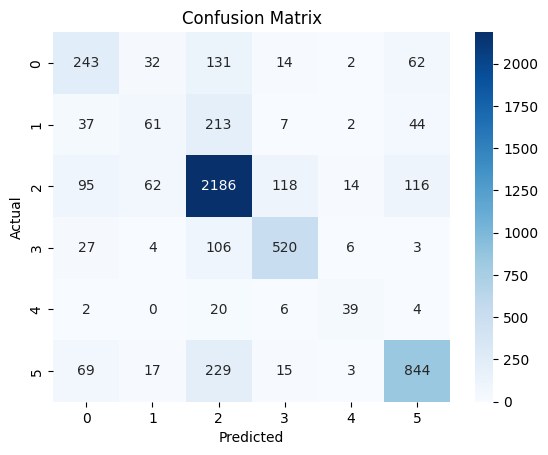

In [110]:
y_pred = knn.predict(x_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [86]:
# k_values = range(1, 61)

# scores = []

# for k in k_values:
#     score = cross_val_score(knn, x_train, y_train, cv=5).mean()
#     scores.append(score)
#     print(f"k = {k} → Accuracy = {score:.4f}")

In [111]:
print(df['class'].value_counts())

class
2    12954
5     5884
3     3329
0     2418
1     1821
4      356
Name: count, dtype: int64
